In [19]:
import pandas as pd
from author_properties_transformers import author_influence



from datetime import timezone, datetime
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import make_pipeline, make_union
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.preprocessing import FunctionTransformer
import seaborn as sns

In [2]:
df = pd.read_csv("../Data/wsb_full_not_deleted_withdt.csv")

df = df.loc[df.author != "None"]


C:\Users\lnajt\anaconda3\envs\Erdos_Institute\lib\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (45,88,117,118,119,122,123,124,125) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:

df ["created_datetime_utc"] = df["created_utc"].apply(datetime.utcfromtimestamp)
df['weektime'] = df['created_datetime_utc'].apply( lambda x : x.weekday()*24 + x.hour)
df['time_of_day'] = df['created_datetime_utc'].apply( lambda x : x.hour)

In [4]:
df_cleaned = df[ [  'id', 'title', 'author', 'ups', 'weektime', 'time_of_day', 'selftext']]

In [23]:
c = df.dropna( axis = 1, how = 'all')

In [27]:
c = c.drop(columns = ["comment_limit", "comment_sort", "_reddit", "subreddit", "saved",  ])

In [29]:
c = c.drop(columns = ["clicked", "subreddit_name_prefixed"  ])

In [33]:
c[~c.is_gallery.isnull()]

,Unnamed: 0,selftext,user_reports,gilded,title,link_flair_richtext,hidden,pwls,link_flair_css_class,downs,...,poll_data,event_start,event_end,event_is_live,is_gallery,gallery_data,collections,created_datetime_utc,weektime,time_of_day
25074,171394,NaN,[],0,First post: how the week started vs how the we...,"[{'e': 'text', 't': 'Loss'}]",False,7,loss,0,...,NaN,NaN,NaN,NaN,True,"{'items': [{'media_id': 'lr91gtdcmdb51', 'id':...",NaN,2020-07-17 08:15:55,104,8
25122,171690,NaN,[],0,Proper post,"[{'e': 'text', 't': 'Gain'}]",False,7,profit,0,...,NaN,NaN,NaN,NaN,True,"{'items': [{'media_id': '510dja4nbnb51', 'id':...",NaN,2020-07-18 16:53:52,136,16
25235,172494,NaN,[],0,I Just Bet My Entire ThinkOrSwim Account on my...,"[{'e': 'text', 't': 'YOLO'}]",False,7,yolo,0,...,NaN,NaN,NaN,NaN,True,{'items': [{'caption': 'Took profit on my Amaz...,NaN,2020-07-20 19:57:04,19,19
25457,173833,NaN,[],0,Big Wednesday! Big Wave Hunters!,"[{'e': 'text', 't': 'Gain'}]",False,7,profit,0,...,NaN,NaN,NaN,NaN,True,"{'items': [{'media_id': 'eng5eppz0hc51', 'id':...",NaN,2020-07-22 20:50:18,68,20
25958,177645,NaN,[],0,Can you tell where I started trading options?,"[{'e': 'text', 't': 'Loss'}]",False,7,loss,0,...,NaN,NaN,NaN,NaN,True,"{'items': [{'media_id': '5z4ye7s81md51', 'id':...",NaN,2020-07-28 14:41:58,38,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97733,959043,NaN,[],0,YOLO the last of it. Today on GME. Bought 45 m...,"[{'e': 'text', 't': 'YOLO'}]",False,7,yolo,0,...,NaN,NaN,NaN,NaN,True,"{'items': [{'media_id': '0u1qzu8dijx61', 'id':...",NaN,2021-05-06 18:04:09,90,18
97754,959228,NaN,[],0,Look at the second pic you retailers!,"[{'e': 'text', 't': 'Meme'}]",False,7,meme,0,...,NaN,NaN,NaN,NaN,True,"{'items': [{'media_id': 'wp0phcf04jx61', 'id':...",NaN,2021-05-06 16:45:57,88,16
97757,959276,NaN,[],1,"Not quite food stamps, but definitely not a la...","[{'e': 'text', 't': 'Loss'}]",False,7,loss,0,...,NaN,NaN,NaN,NaN,True,{'items': [{'caption': 'Around 40k into gme > ...,NaN,2021-05-06 16:24:51,88,16
97788,959494,NaN,[],1,Schwab gently suggests maybe options trading i...,"[{'e': 'text', 't': 'Loss'}]",False,7,loss,0,...,NaN,NaN,NaN,NaN,True,"{'items': [{'media_id': '9ldae358jix61', 'id':...",NaN,2021-05-06 14:47:09,86,14


In [5]:
author_stat_features = FeatureUnion([('aggsum', author_influence(kind = 'sum')), 
                           ('aggmean', author_influence(kind = 'mean')), 
                           ('aggmedian', author_influence(kind = 'median')),
                            ('aggcount', author_influence(kind = 'count')),
                              #('aggpowerlaw', author_influence(kind = 'power_law')) # slows things down a lot      
                           
                           ])
# testing:
# todo: make sure that nothing gets modified inplace that shouldnt be...
# author_stat_features
# author_stat_features.fit(df)
# pd.DataFrame(author_stat_features.transform(df))


In [6]:

time_features = make_union( make_column_transformer(  (FunctionTransformer(lambda x : x), ["weektime", "time_of_day"] ),
                                                   )            
                          )

#time_features.fit_transform(df_cleaned)


In [8]:
#nlp_features = FeatureUnion([])

In [9]:


all_features = make_union ( author_stat_features, time_features )

working on LinearRegression()


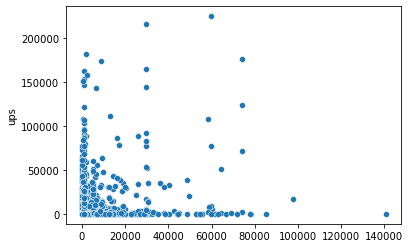

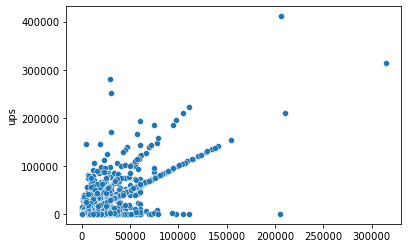

[-3.28277545 -2.70359793 -1.42018051  0.02421643 -0.08948711]
working on XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=2, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)


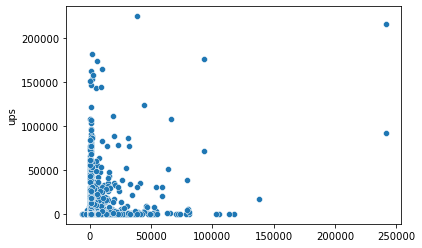

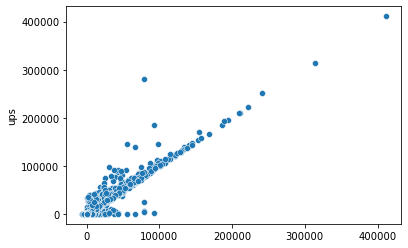

[-4.09842257 -3.13269524 -2.12808268  0.02198789 -0.05358709]


In [21]:
def run_experiment(model, df):
    
    



    X_train, X_test, y_train, y_test = train_test_split(df, df.ups,
                                                    random_state=0)

    print("working on", model)

    pipe = make_pipeline(all_features, model)
    pipe.fit(X_train, y_train)

    pipe.predict(X_test)

    sns.scatterplot(x = pipe.predict(X_test), y = y_test)
    plt.show()
    sns.scatterplot(x = pipe.predict(X_train), y = y_train)
    plt.show()
    
    scores = cross_val_score(pipe, df, df.ups)
    print(scores)

for model in [LinearRegression(), xgb.XGBRegressor(random_state=2)]:
    run_experiment(model, df_cleaned)


In [ ]:
for model in [LinearRegression(), xgb.XGBRegressor(random_state=2)]:
    run_experiment(model, df_cleaned)

In [12]:
# Todo: Do DV to tune hyperparameters.